In [1]:
%load_ext autoreload
%autoreload 2

import time
import os
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from dataset2 import AcceptanceDataset
from memflow.ttH.classifier.classifier_models import *

from ttH_dataclasses_acceptance import ttHHardDataset, ttHRecoDataset

from memflow.ttH.classifier.classifier_callbacks import *
from memflow.ttH.models.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

In [2]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
)
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
)
print(data_hard)

Data object
Loaded branches:
   ... file: 1903554
   ... sample: 1903554
   ... tree: 1903554
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi

In [ ]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(hard_dataset)

reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Selecting 756642 events out of 1903554
Before cut: 1903554 events
After cut: 756642 events


KeyboardInterrupt: 

In [ ]:
dataset = AcceptanceDataset(
    hard_dataset = hard_dataset,
    reco_dataset = reco_dataset,
)

train_frac = 0.8 # from 0.7
indices = torch.arange(len(dataset))
sep = int(train_frac*len(dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

dataset_train = torch.utils.data.Subset(dataset,train_indices)
dataset_valid = torch.utils.data.Subset(dataset,valid_indices)

print (f'Dataset : training {len(dataset_train)} / validation {len(dataset_valid)}')

batch_size = 1024 # from 1024

loader_train = DataLoader(
    dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_valid = DataLoader(
    dataset_valid,
    batch_size = 10000,
    shuffle = False,
)
print (f'Batching {len(loader_train)} / Validation {len(loader_valid)}')

Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 756642 events, 168536 selected
For entry 1 : from 231528 events, 168536 selected
Dataset : training 605313 / validation 151329
Batching 592 / Validation 16


Before Preprocessing


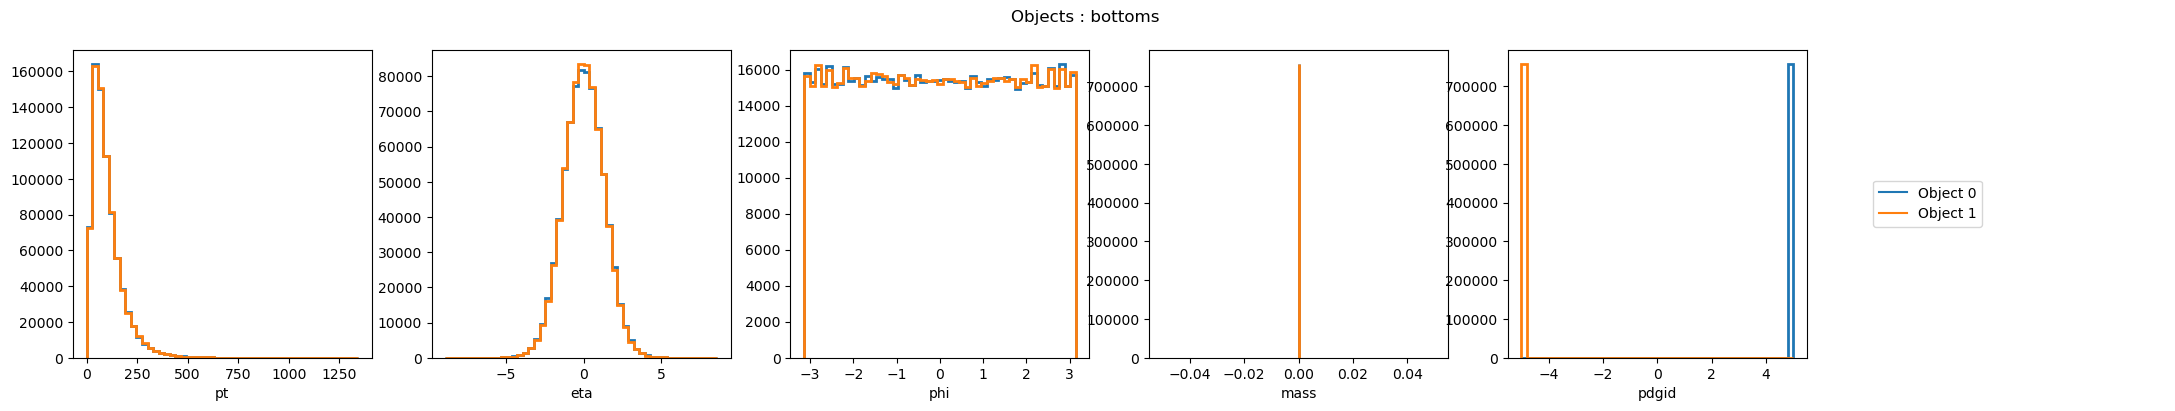

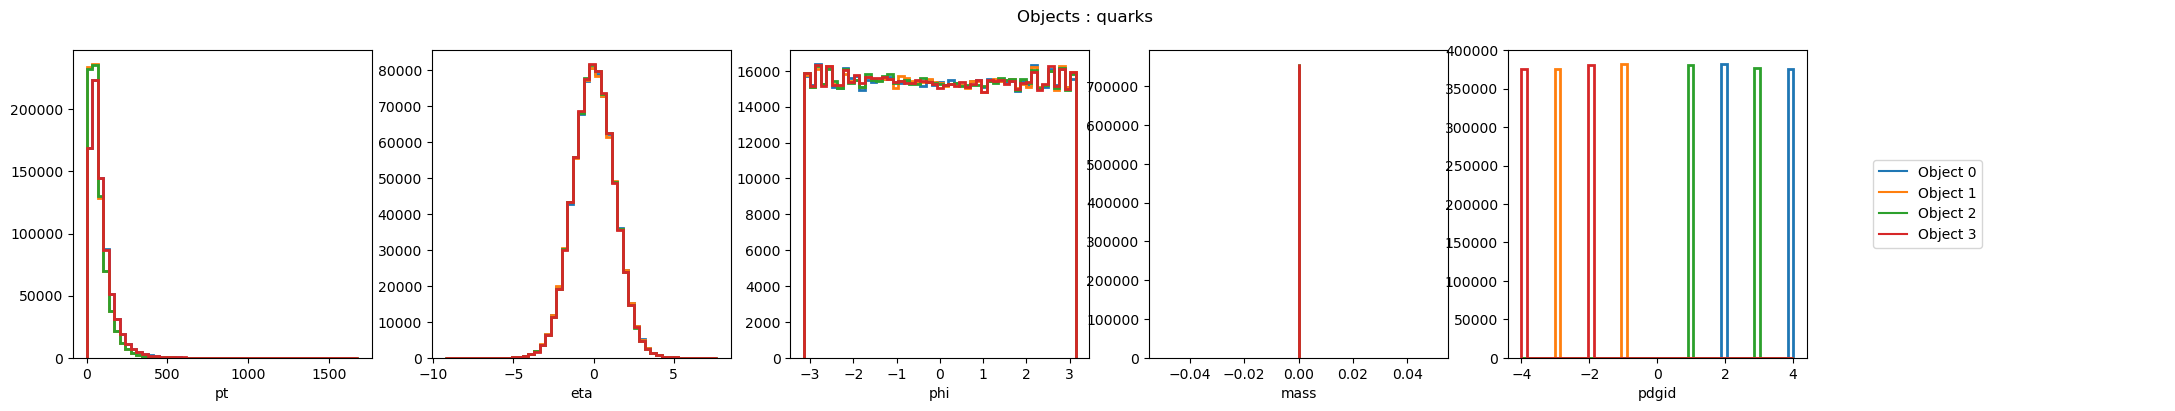

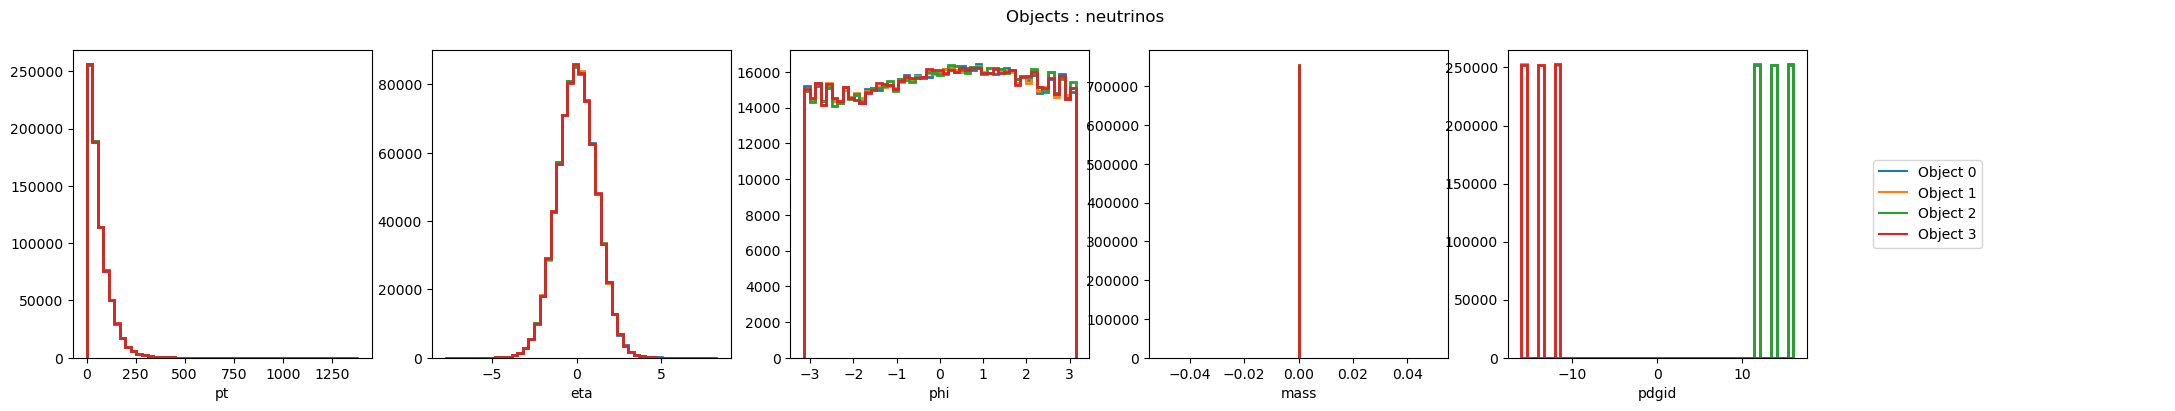

After prerocessing


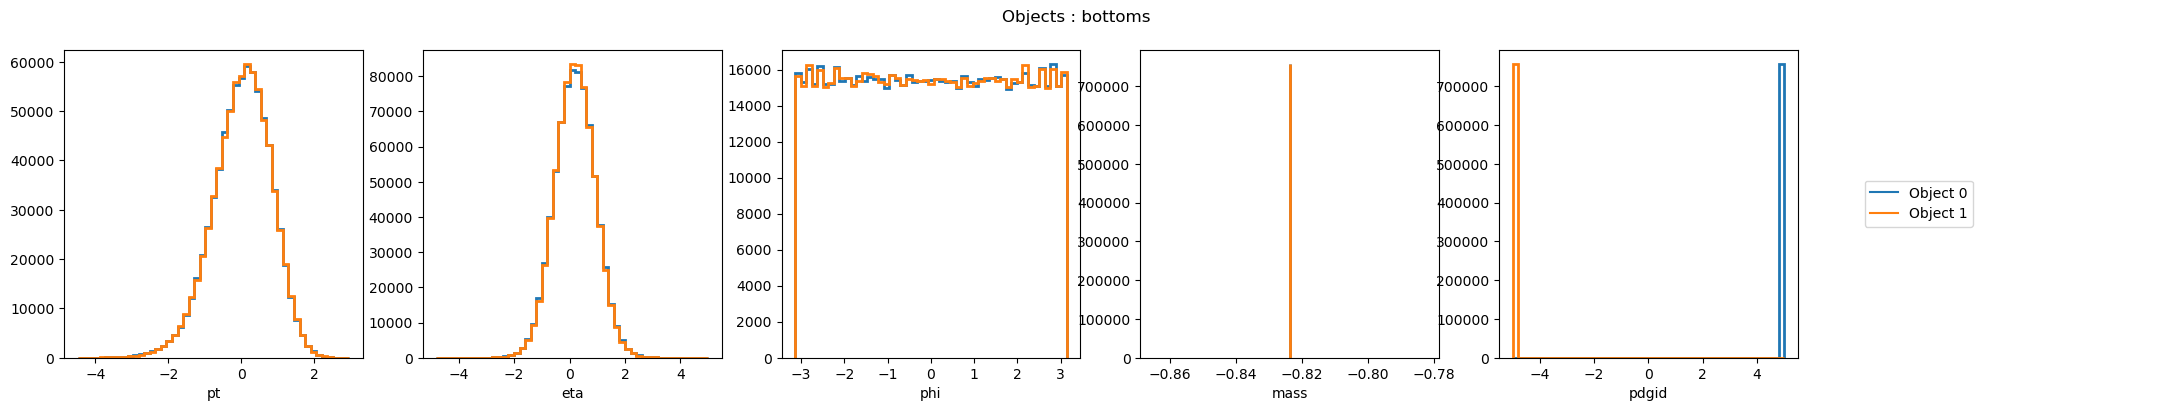

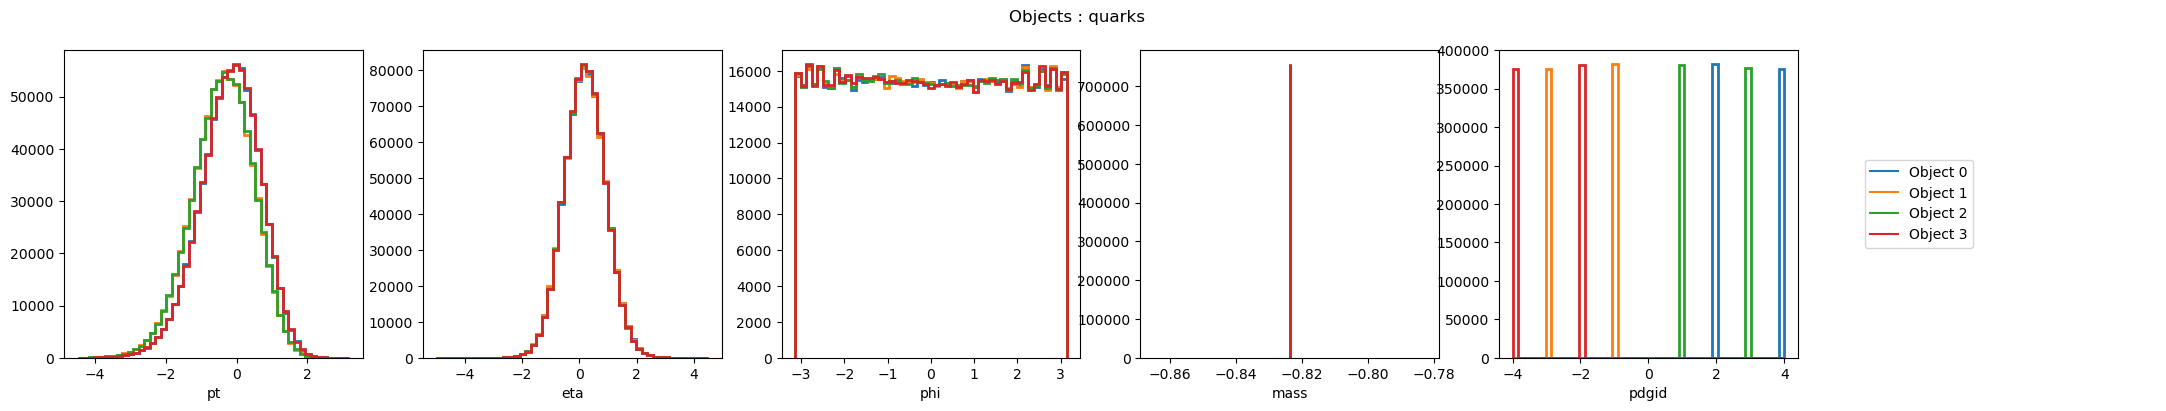

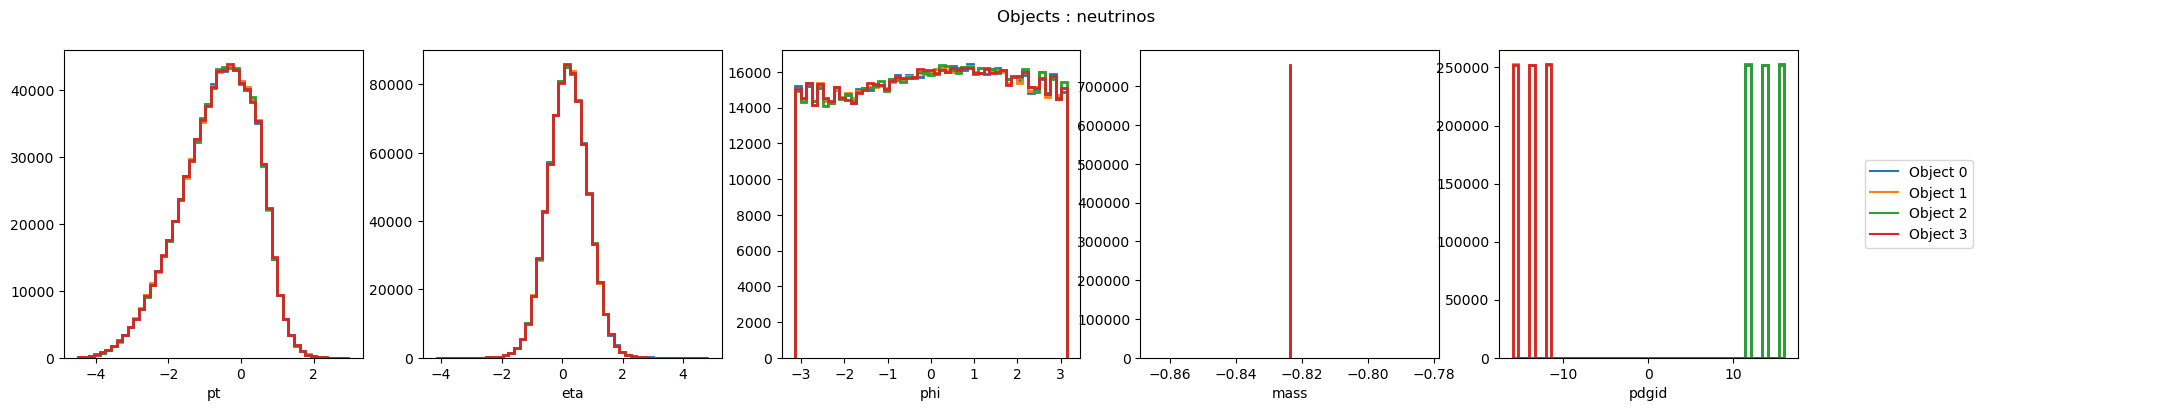

In [ ]:
print("Before Preprocessing")
dataset.hard_dataset.plot(selection=True, raw=True,log=False)
print("After prerocessing")
dataset.hard_dataset.plot(selection=True, raw=False,log=False,fields_to_plot=['pt','eta','phi','mass','pdgid'])

# ttH Model

In [ ]:
# We want a model that can classify between selected (1) and not selected (0)
# We can either use a fully connected network
# backbone : DNN
# head : DNN

# backbone = BaseMLP(
#     dim_in = dataset.flatten_dim,
#     dim_out = None,
#     neurons = [64]*7, # changed from [64]*3
#     hidden_activation = nn.GELU,
#     batch_norm = True,
# )
# head = BaseMLP(
#     dim_in = 64, # changed from 64 to match the last layer of the backbone
#     dim_out = 1,
#     output_activation = nn.Sigmoid,
#     batch_norm = True,
# )

# Or we can use
# backbone : transformer (+ mean pooling)
# head : DNN

backbone = BaseTransformerEncoder(
    n_particles_per_type = dataset.hard_dataset.number_particles_per_type,
    particle_type_names = dataset.hard_dataset.selection,
    input_features_per_type = dataset.hard_dataset.input_features,
    embed_dims = [64,256],
    activation = nn.GELU,
    num_layers = 6, # From 4
    nhead = 8, # From 4
    dim_feedforward = 512, # From 256
    layer_norm = True,
    dropout = 0.2, # From 0.1
)
head = BaseMLP(
    dim_in = 256,
    neurons = [128, 64, 64, 32], # changed from [128, 64, 32]
    dim_out = 1,
    output_activation = nn.Sigmoid,
    batch_norm = True,
)

# Combine the backbone and head into classifier
#weights = torch.tensor([2.0]) # new line, used because of class imbalance between unselected and selected events, makes the mistakes on minority class (selected) more expensive as its 2.0 compared to 1.0
model = Classifier(
    backbone = backbone,
    head = head,
    loss_function = nn.BCELoss(reduce='none')#nn.BCELoss(weight=weights, reduction='none'), # Was loss_function = nn.BCELoss(reduce='none')
)
print (model)

batch = next(iter(loader_train))

out = model(batch)
print (out.shape)

loss = model.shared_eval(batch,0,'test')
print(loss)

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'head' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['head'])`.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss_function' is an instance of `nn.Module` and

Classifier(
  (backbone): BaseTransformerEncoder(
    (embeddings): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=5, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=256, bias=True)
      )
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


# Training

In [ ]:
acceptance = AcceptanceCallback(
    # Boilerplate arguments #
    dataset = dataset_valid,
    selection = dataset.hard_dataset.selection,
    features_per_type = dataset.hard_dataset.input_features,
    preprocessing = dataset.hard_dataset.preprocessing,
    # Plotting arguments #
    frequency = 5,     # frequency of plotting as callback
    raw = True,        # undo preprocessing (see raw values)
    bins = 50,         # number of bins for histograms
    batch_size=10000,  # number of events per batch for model evaluation
    # N_batch = 1,     # cutdown number of batches used (to make it faster, optional)
    min_selected_events_per_bin = { # rebinning option to make plots nicer (optional)
        'pt'   : 10,
        'eta'  : 10,
        'phi'  : None,
        'mass' : 10,
        'pdgid': None,
    },
    label_names = { # rename option to make plot labels nicer (optional)
        'pt'   : r'$p_T$',
        'eta'  : r'$\eta$',
        'phi'  : r'$\phi$',
        'mass' : r'$M$',
        'pdgid': r'PDG ID',
    }
)

In [ ]:
## Parameters #####
epochs = 1 # 200
steps_per_epoch_train = math.ceil(len(dataset_train)/loader_train.batch_size)

print (f'Training   : Batch size = {loader_train.batch_size} => {steps_per_epoch_train} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-5, weight_decay=1e-5)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode = 'min', 
    factor = 0.5, 
    patience = 10, 
    threshold = 0., 
    threshold_mode = 'rel',  
    cooldown = 0, 
    min_lr = 1e-7,
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True, 
        'name' : 'scheduler',
    }
)


##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    acceptance,
    ModelCheckpoint(save_every_n_epochs=1, save_dir="trained_model_checkpoints/acceptance_checkpoints")
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-ttH',
    experiment_name = 'Acceptance',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename='acceptance_process_DL.ipynb',overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_train,
    val_dataloaders = loader_valid,
)

Training   : Batch size = 1024 => 592 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/themrluke/mem-flow-tth/18f6617e256640b29d44d8b04fa2edf1

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | backbone            | BaseTransformerEncoder | 3.2 M  | train
1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Checkpoint saved at epoch 1: trained_model_checkpoints/acceptance_checkpoints/model_epoch_1.ckpt


`Trainer.fit` stopped: `max_epochs=1` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Acceptance
COMET INFO:     url                   : https://www.comet.com/themrluke/mem-flow-tth/18f6617e256640b29d44d8b04fa2edf1
COMET INFO:   Metrics:
COMET INFO:     scheduler      : 1e-05
COMET INFO:     train/loss_tot : 0.5841405391693115
COMET INFO:     val/loss_tot   : 0.5217075943946838
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Acceptance
COMET INFO:   Parameters:
COMET INFO:     backbone      : BaseTransformerEncoder(
  (embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
     

Predict: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


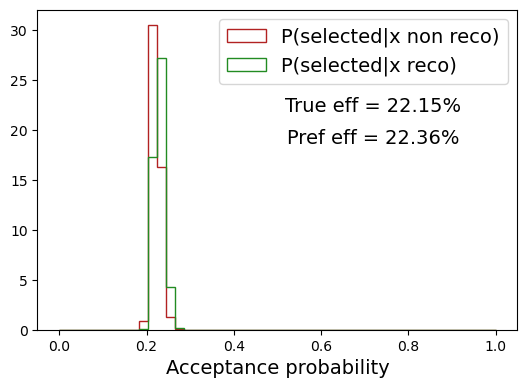

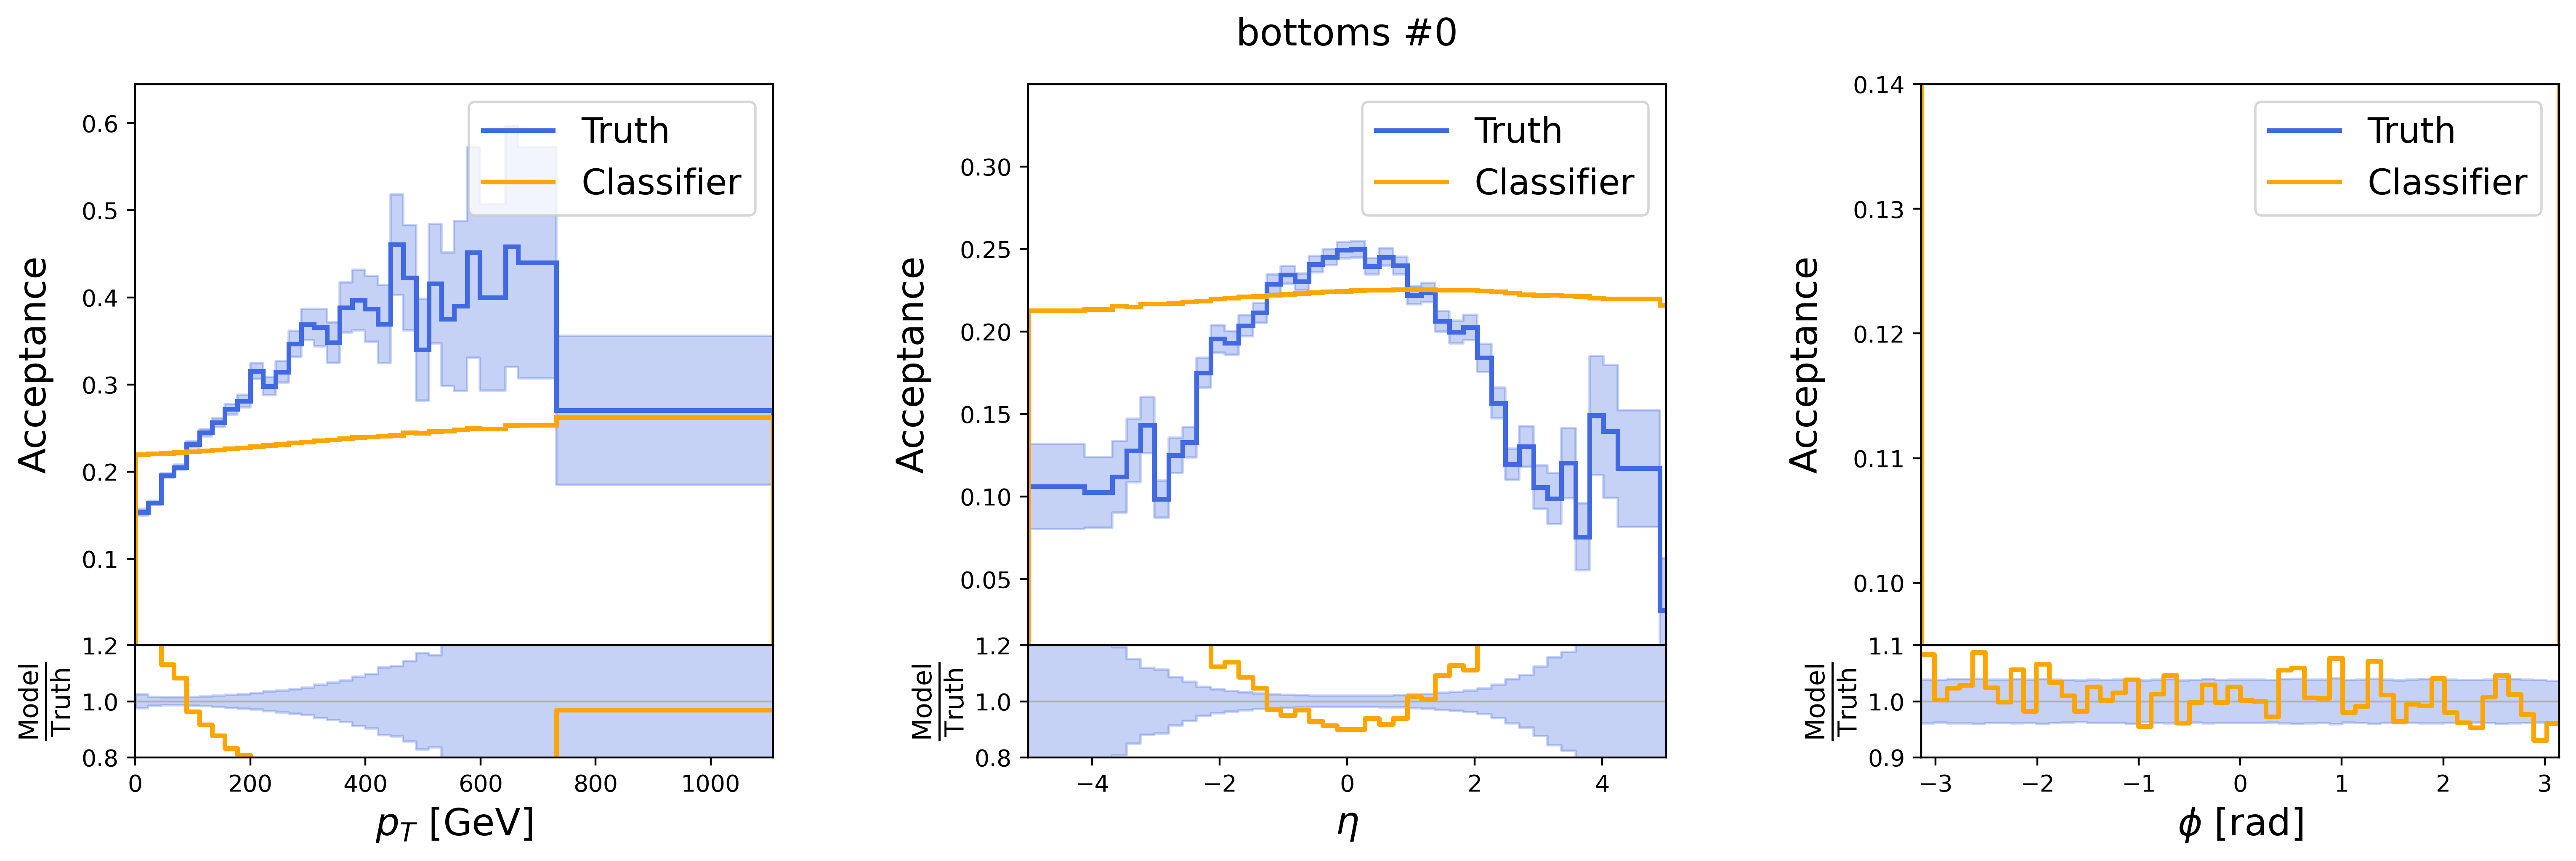

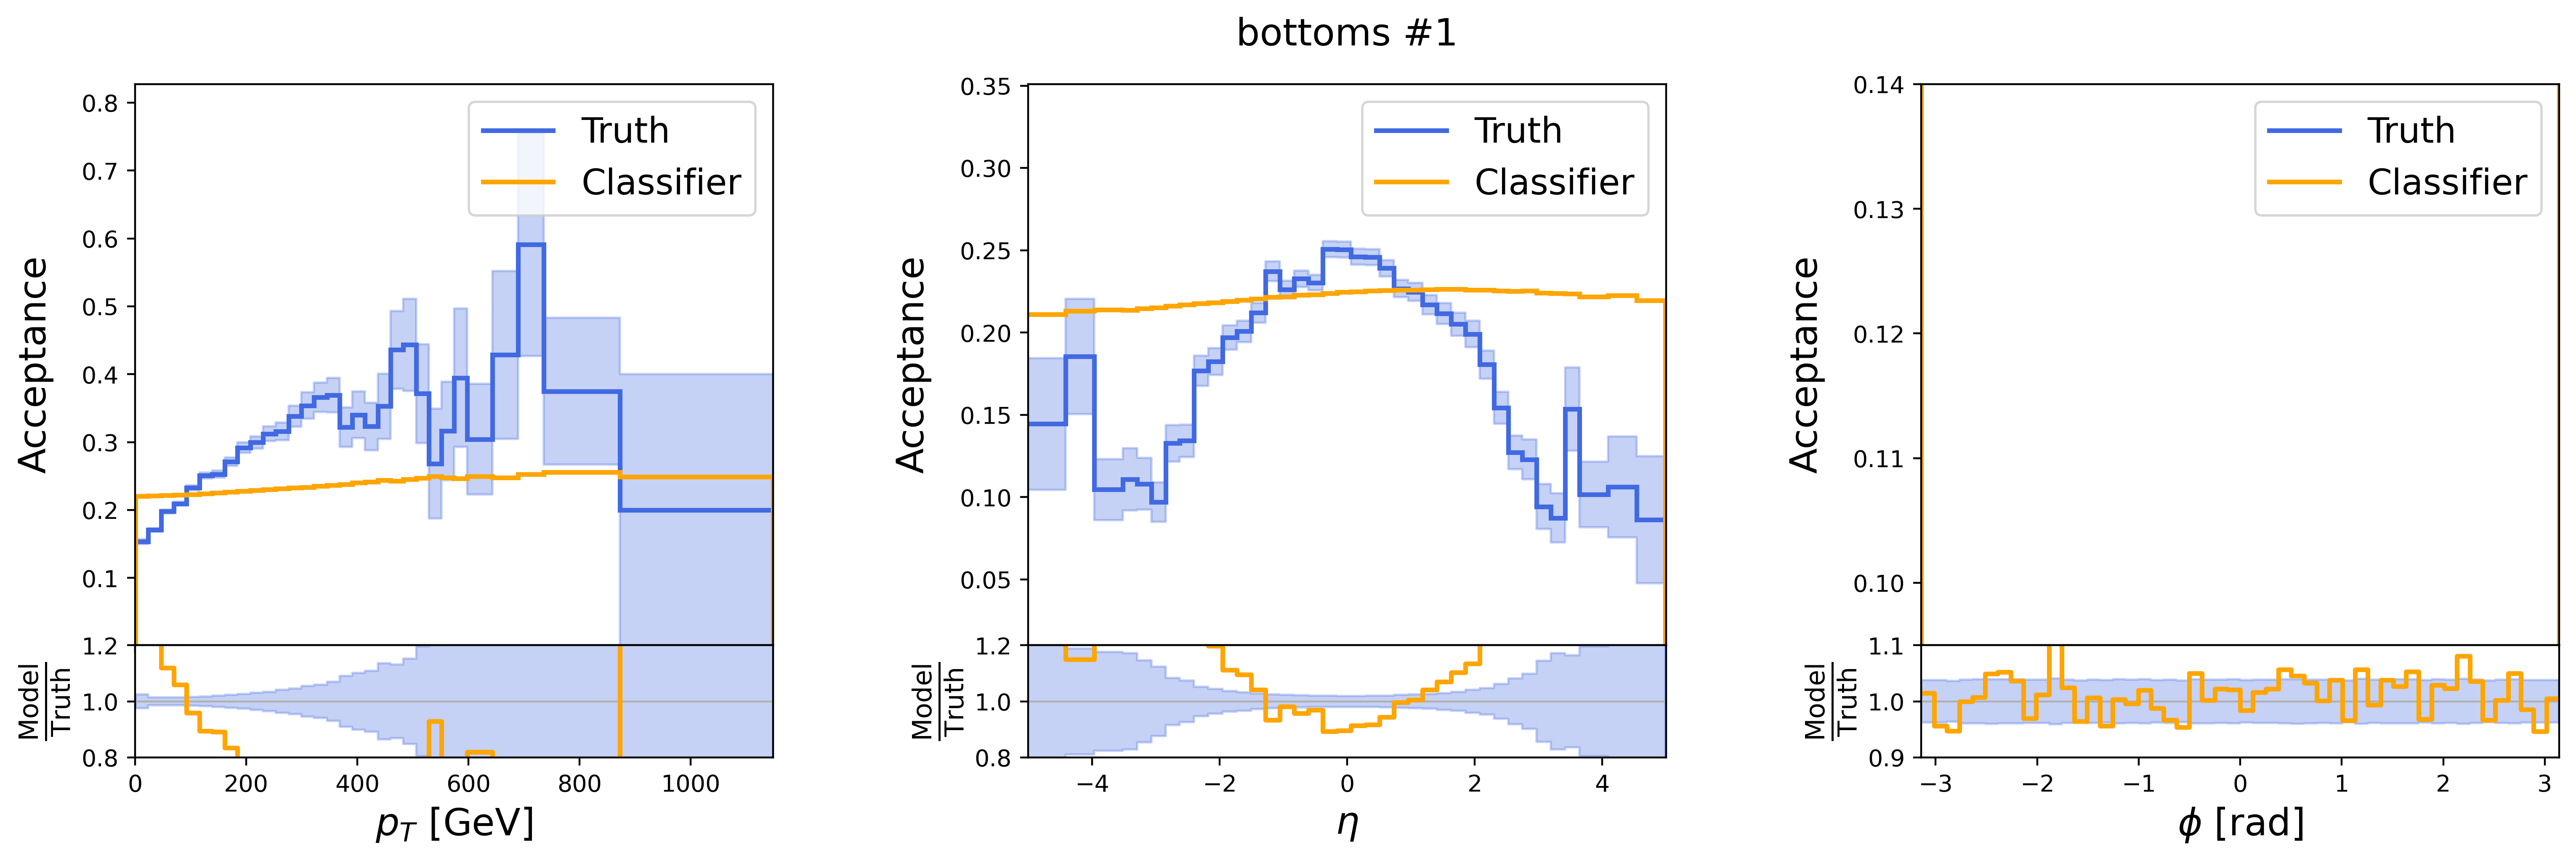

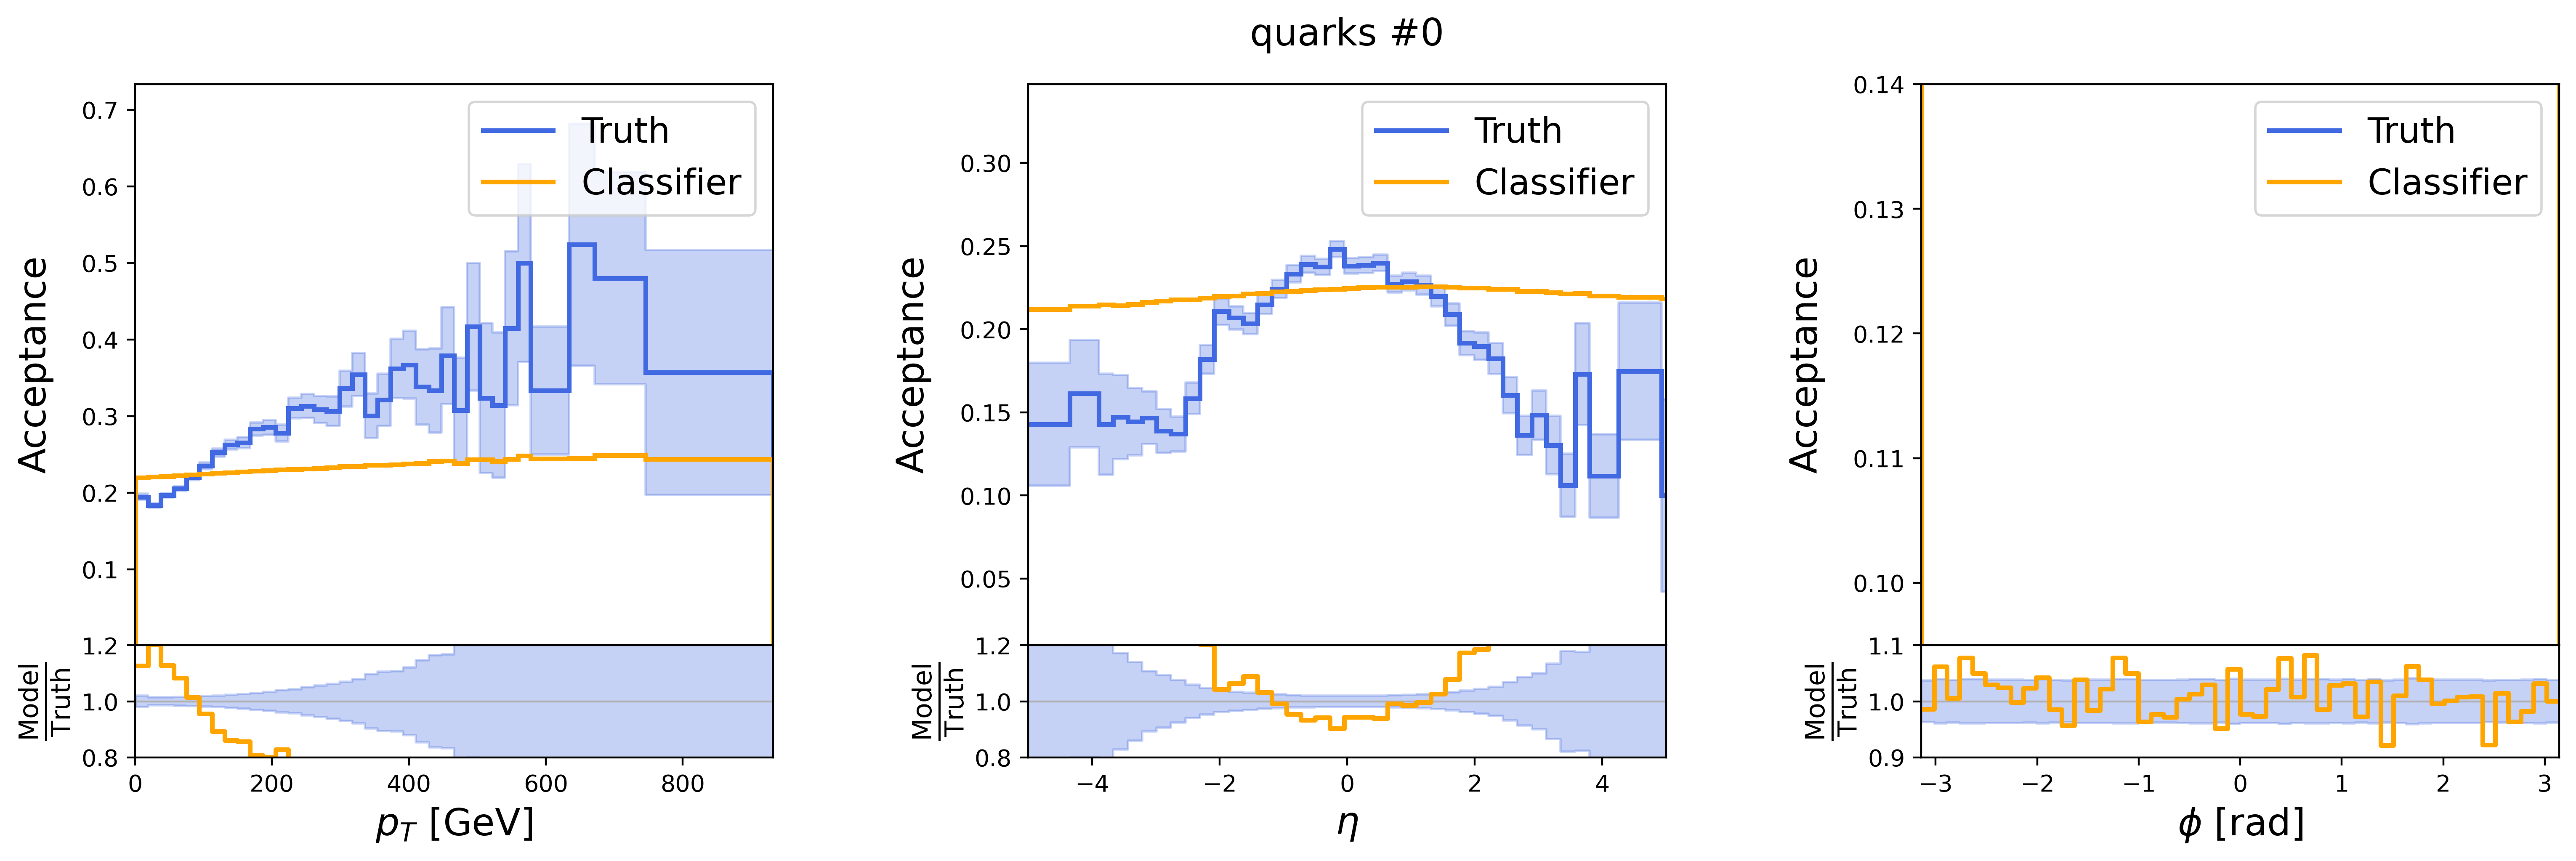

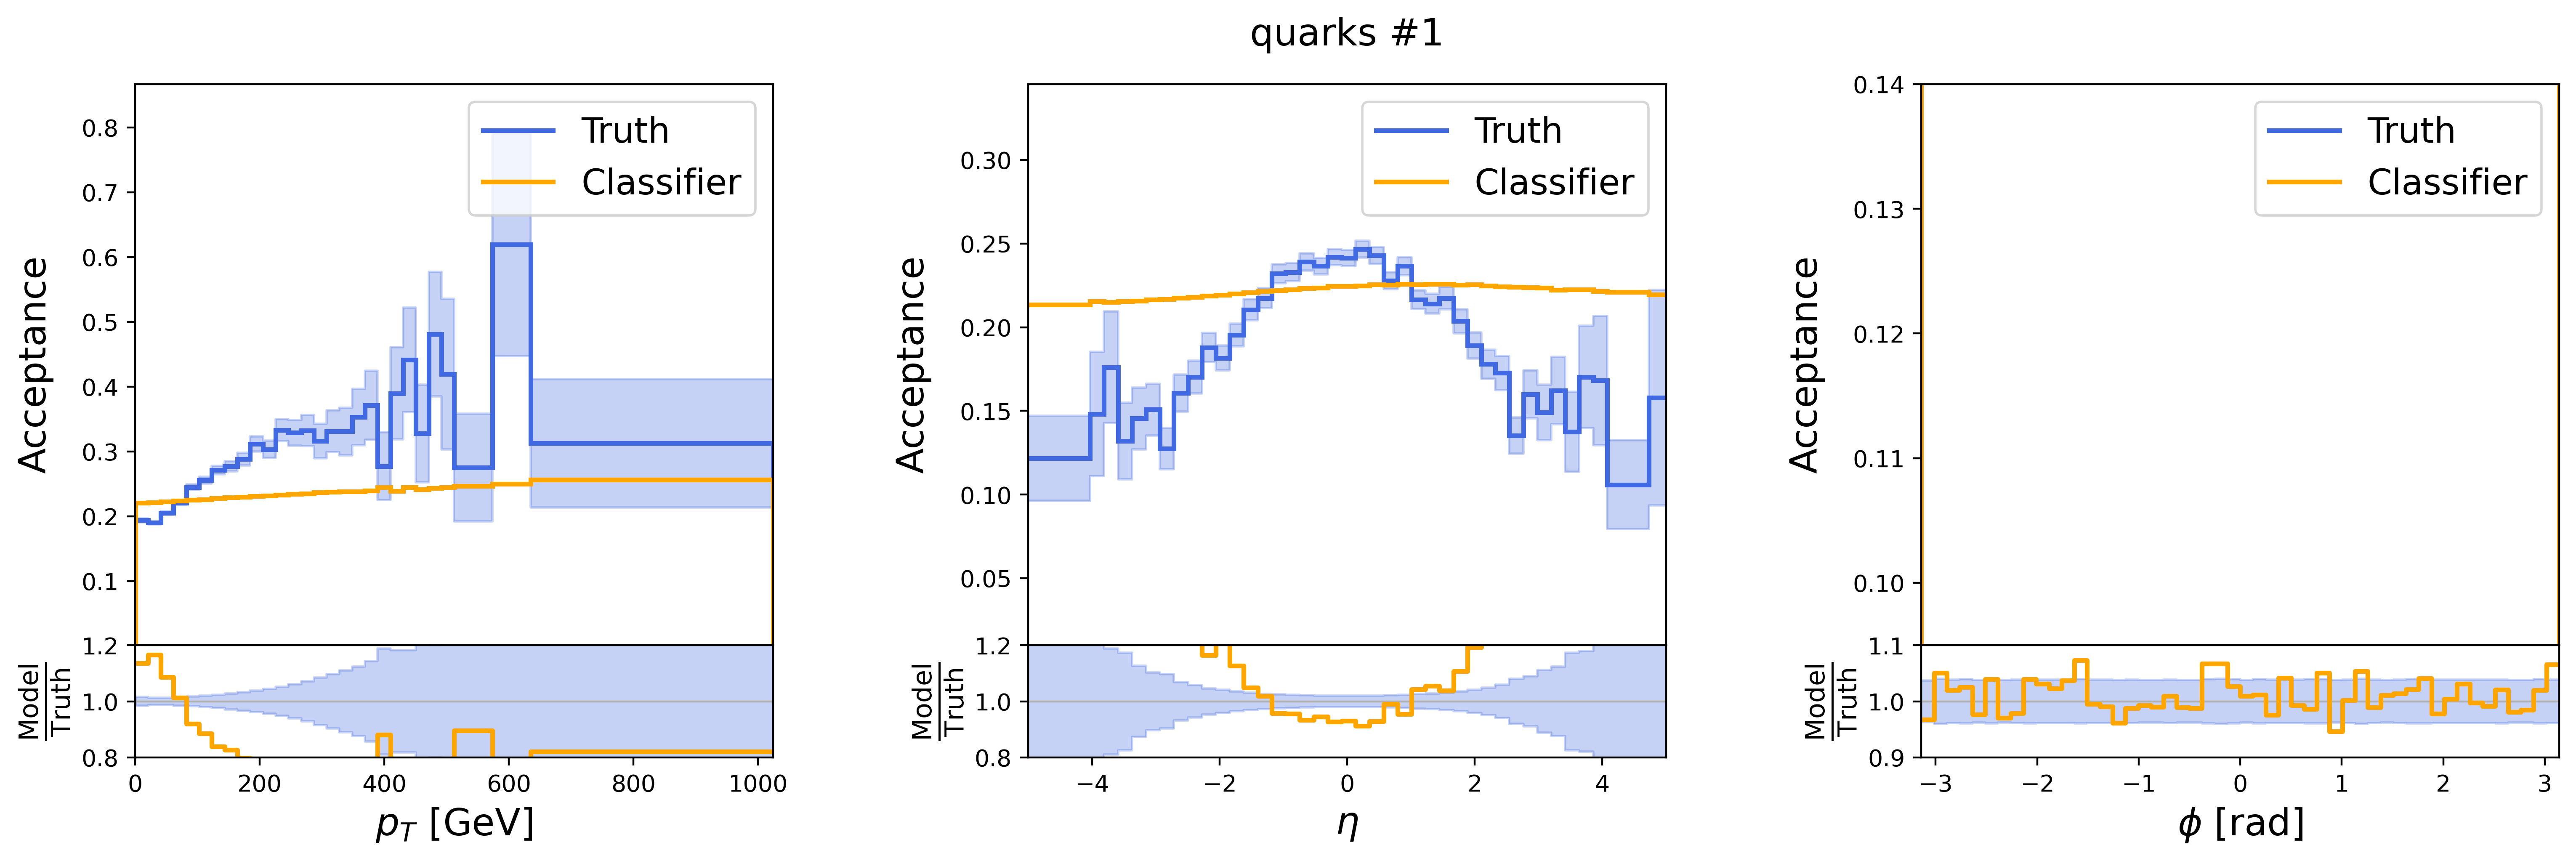

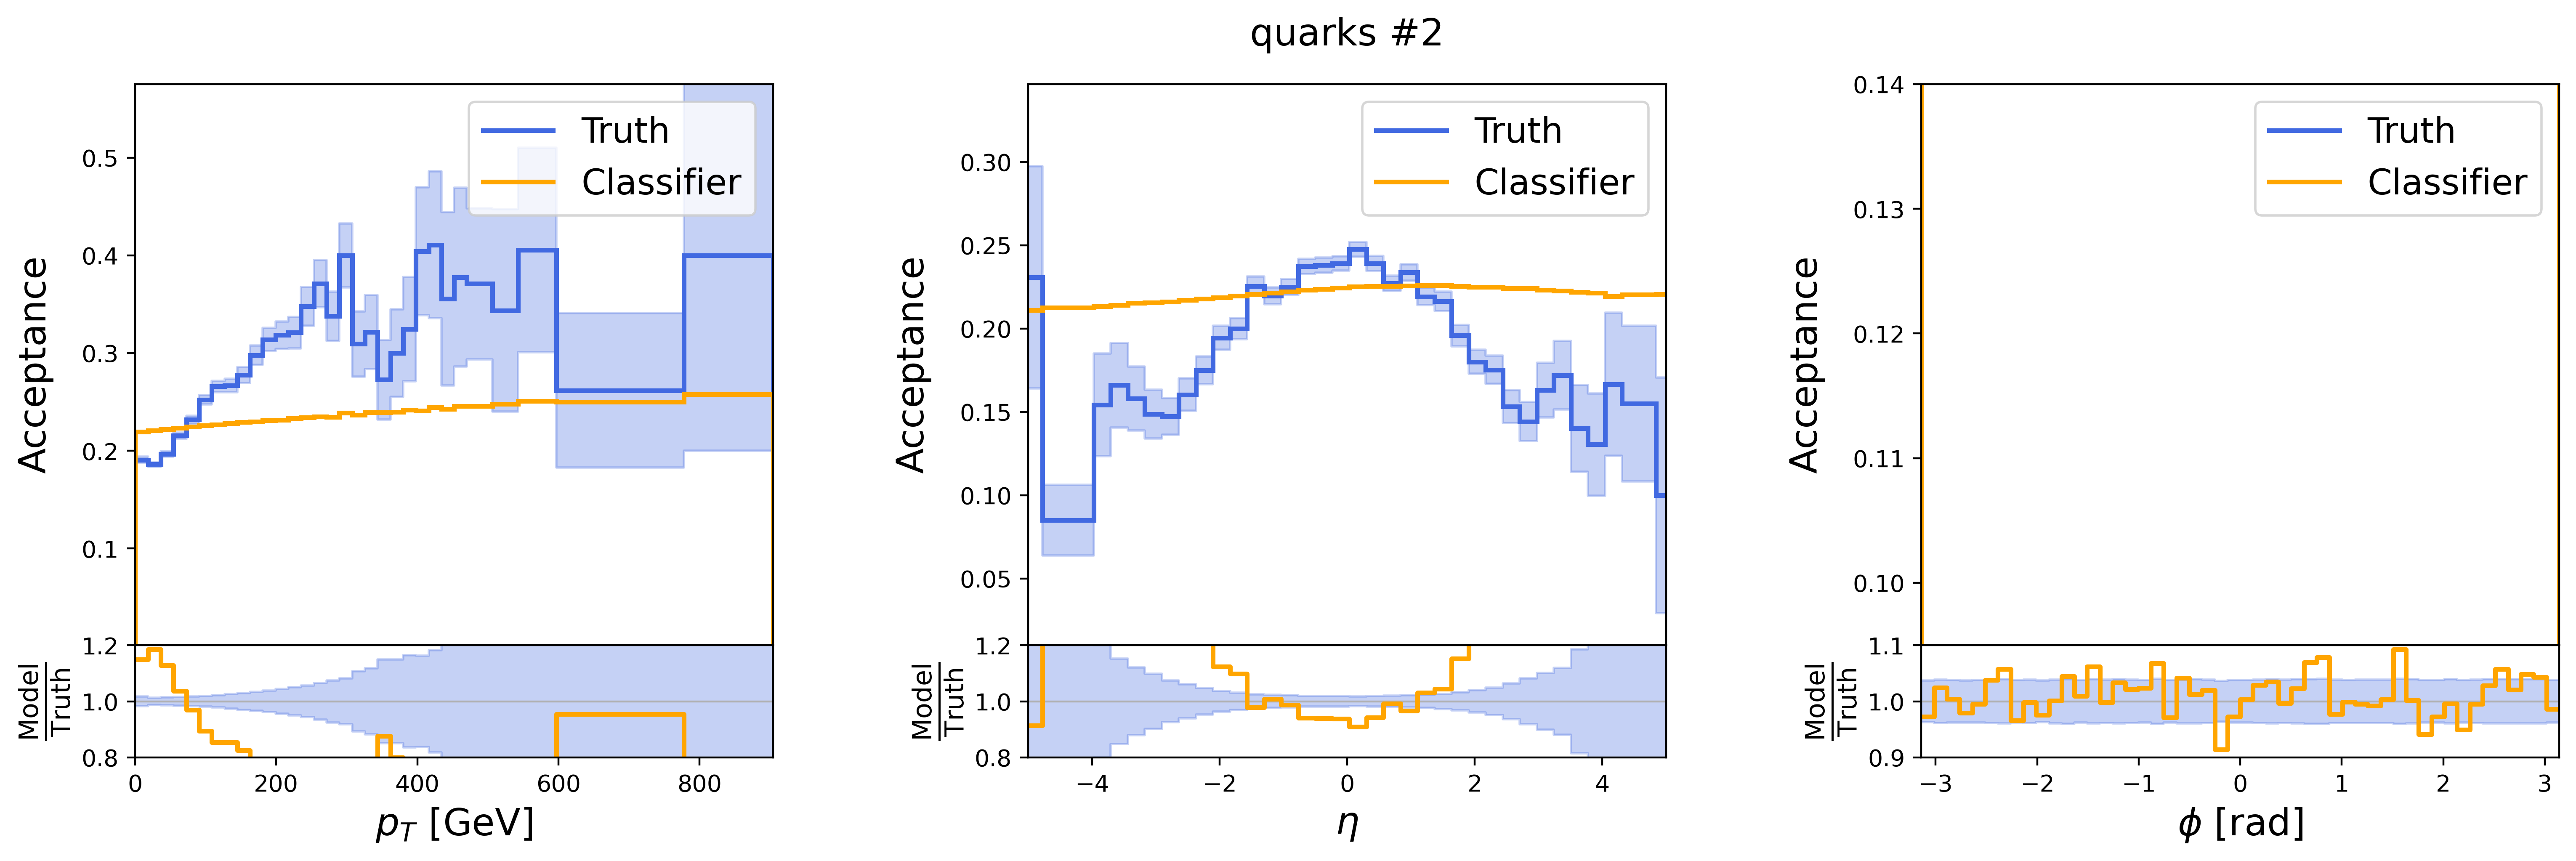

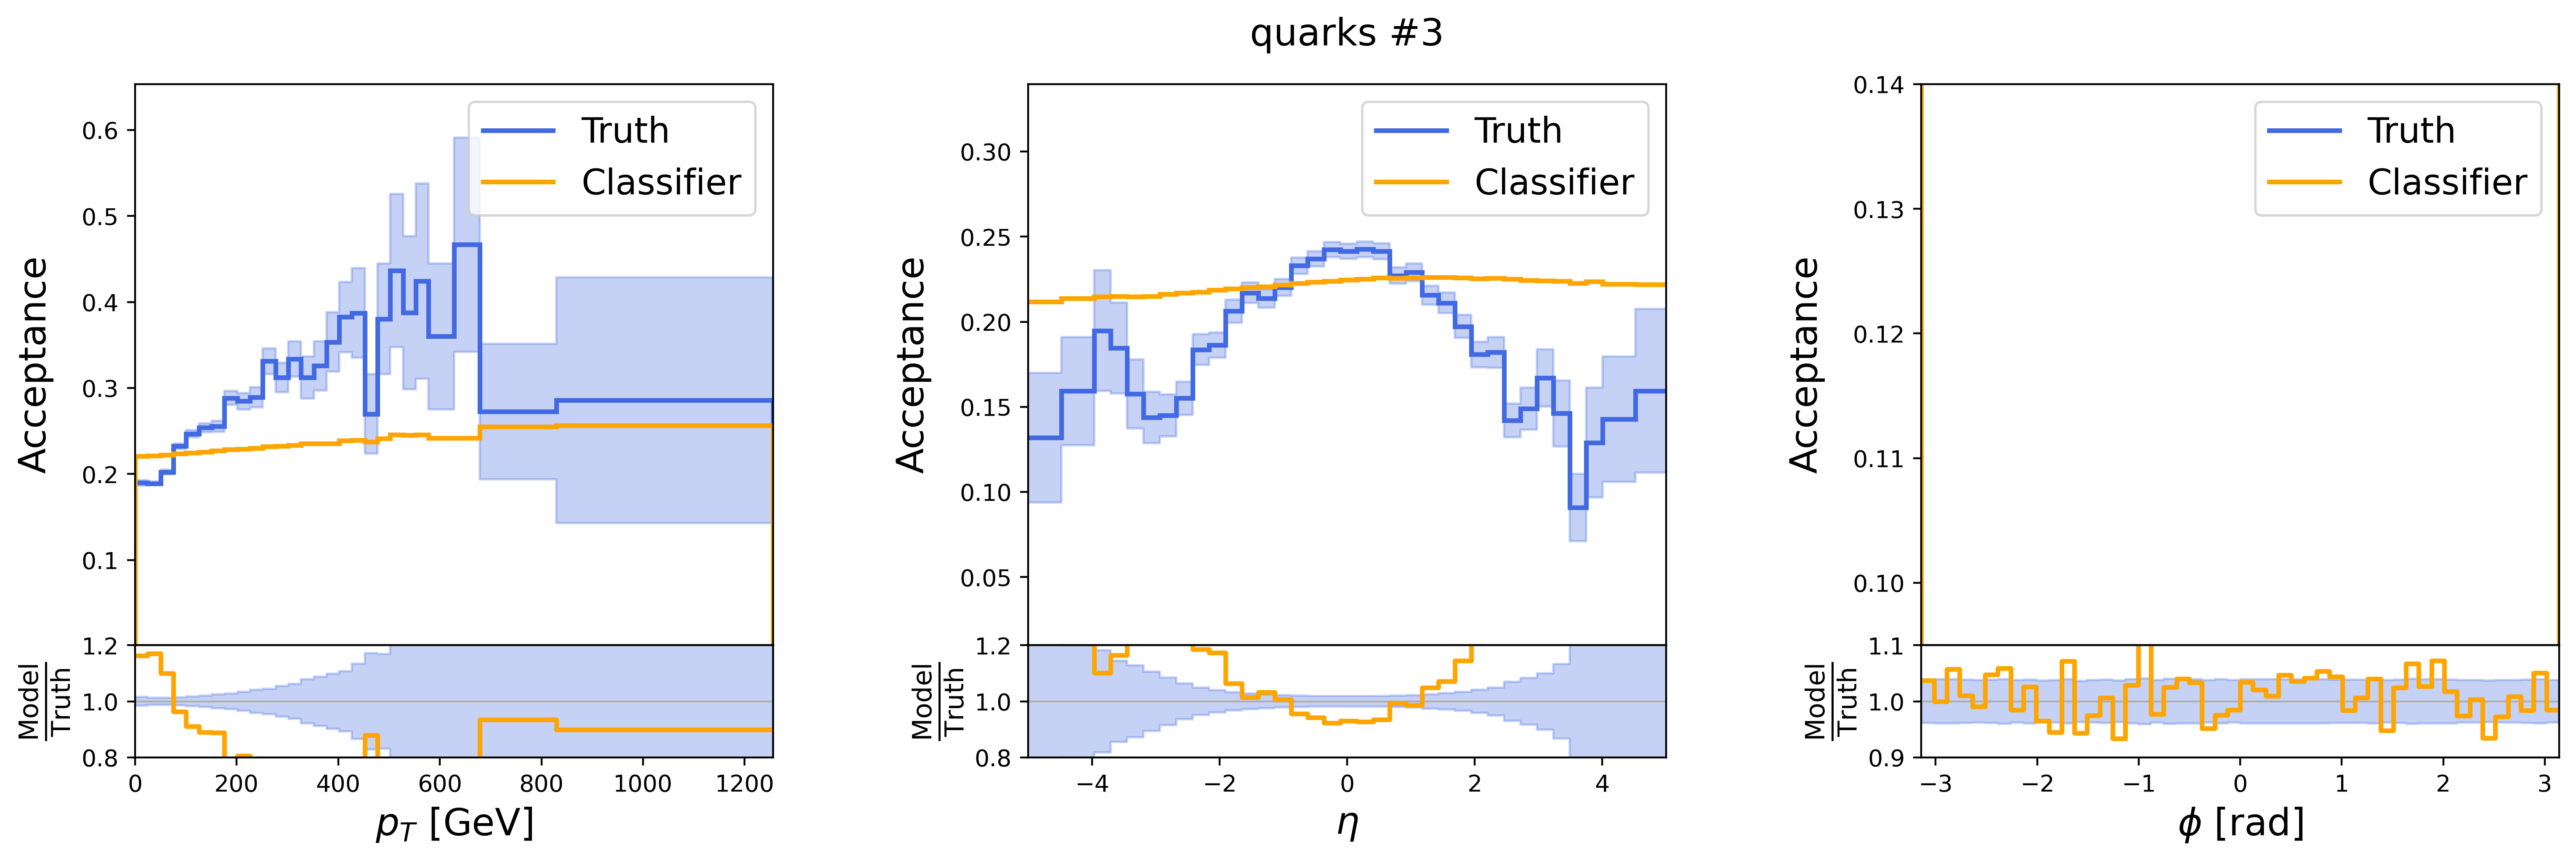

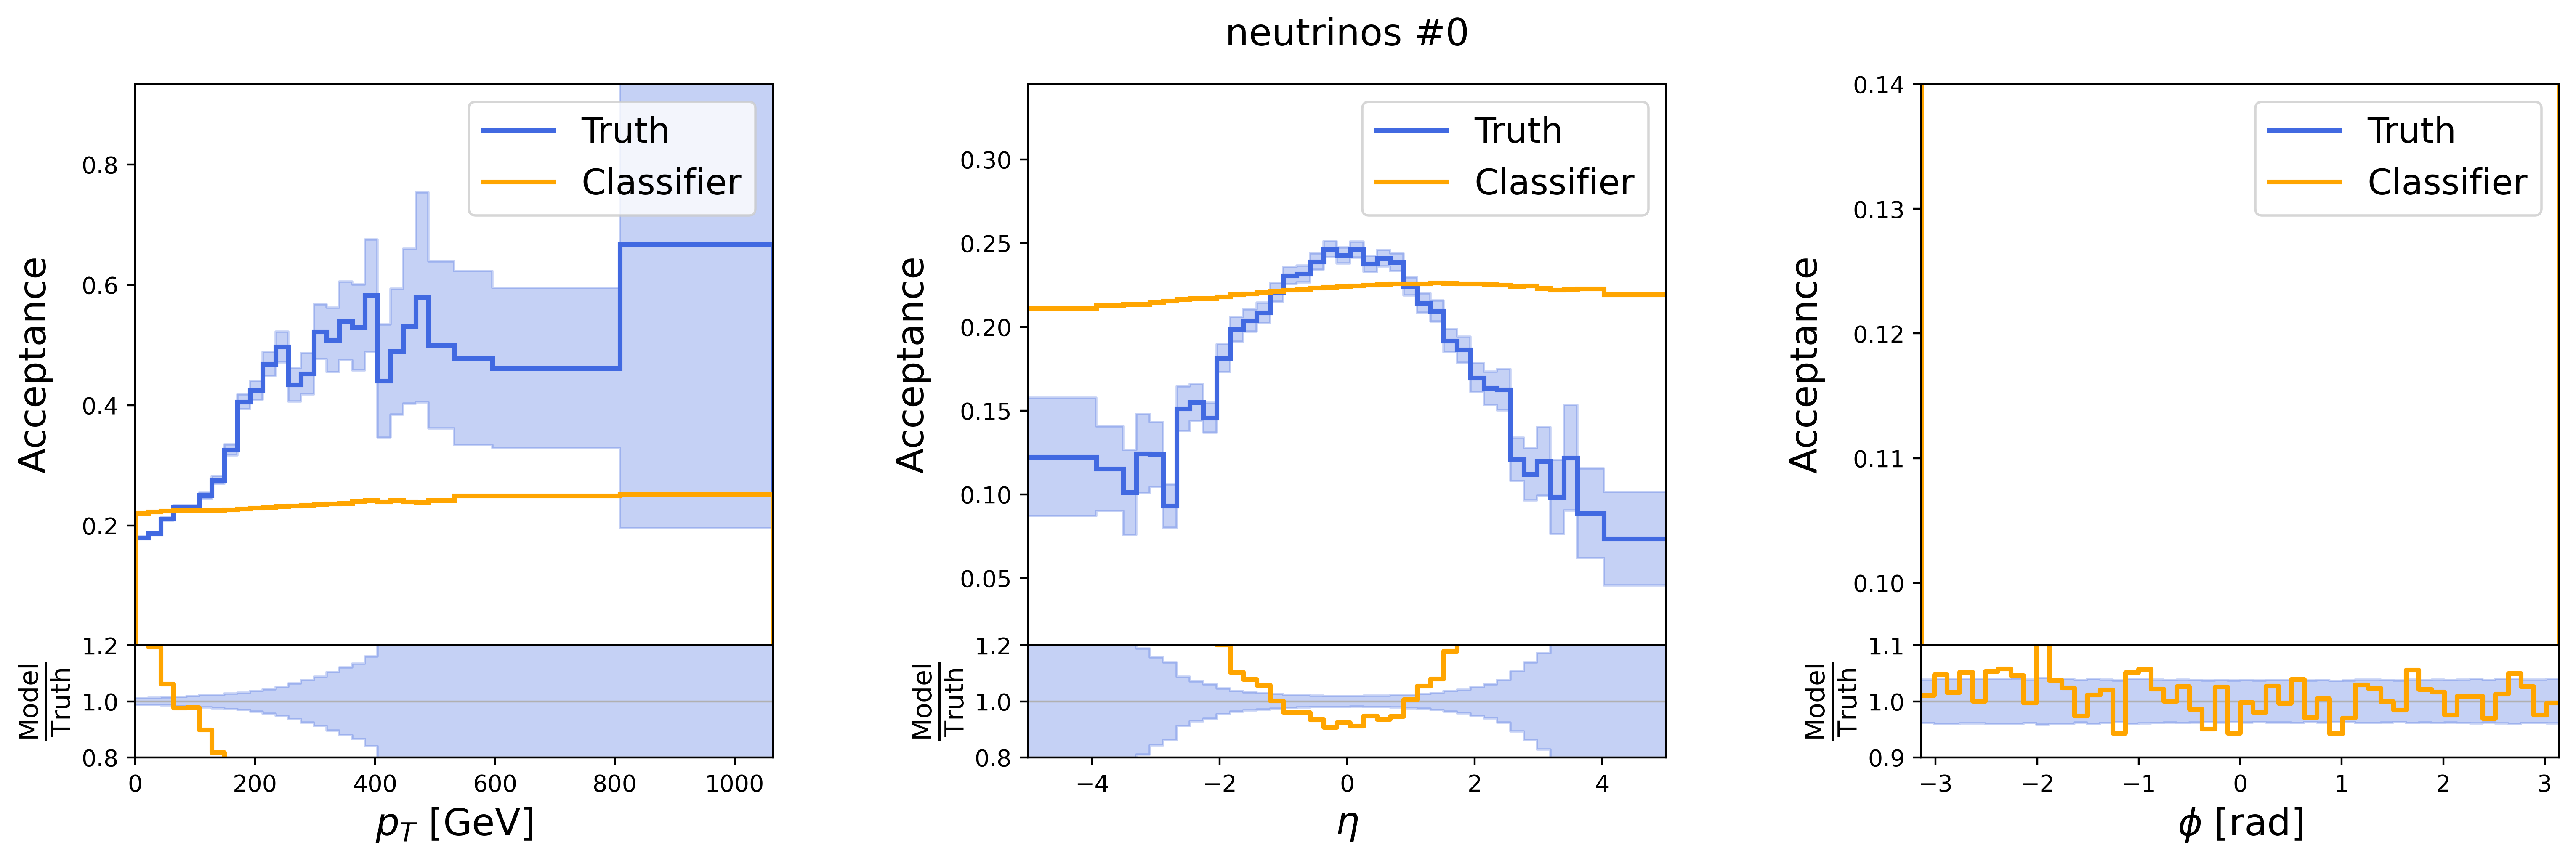

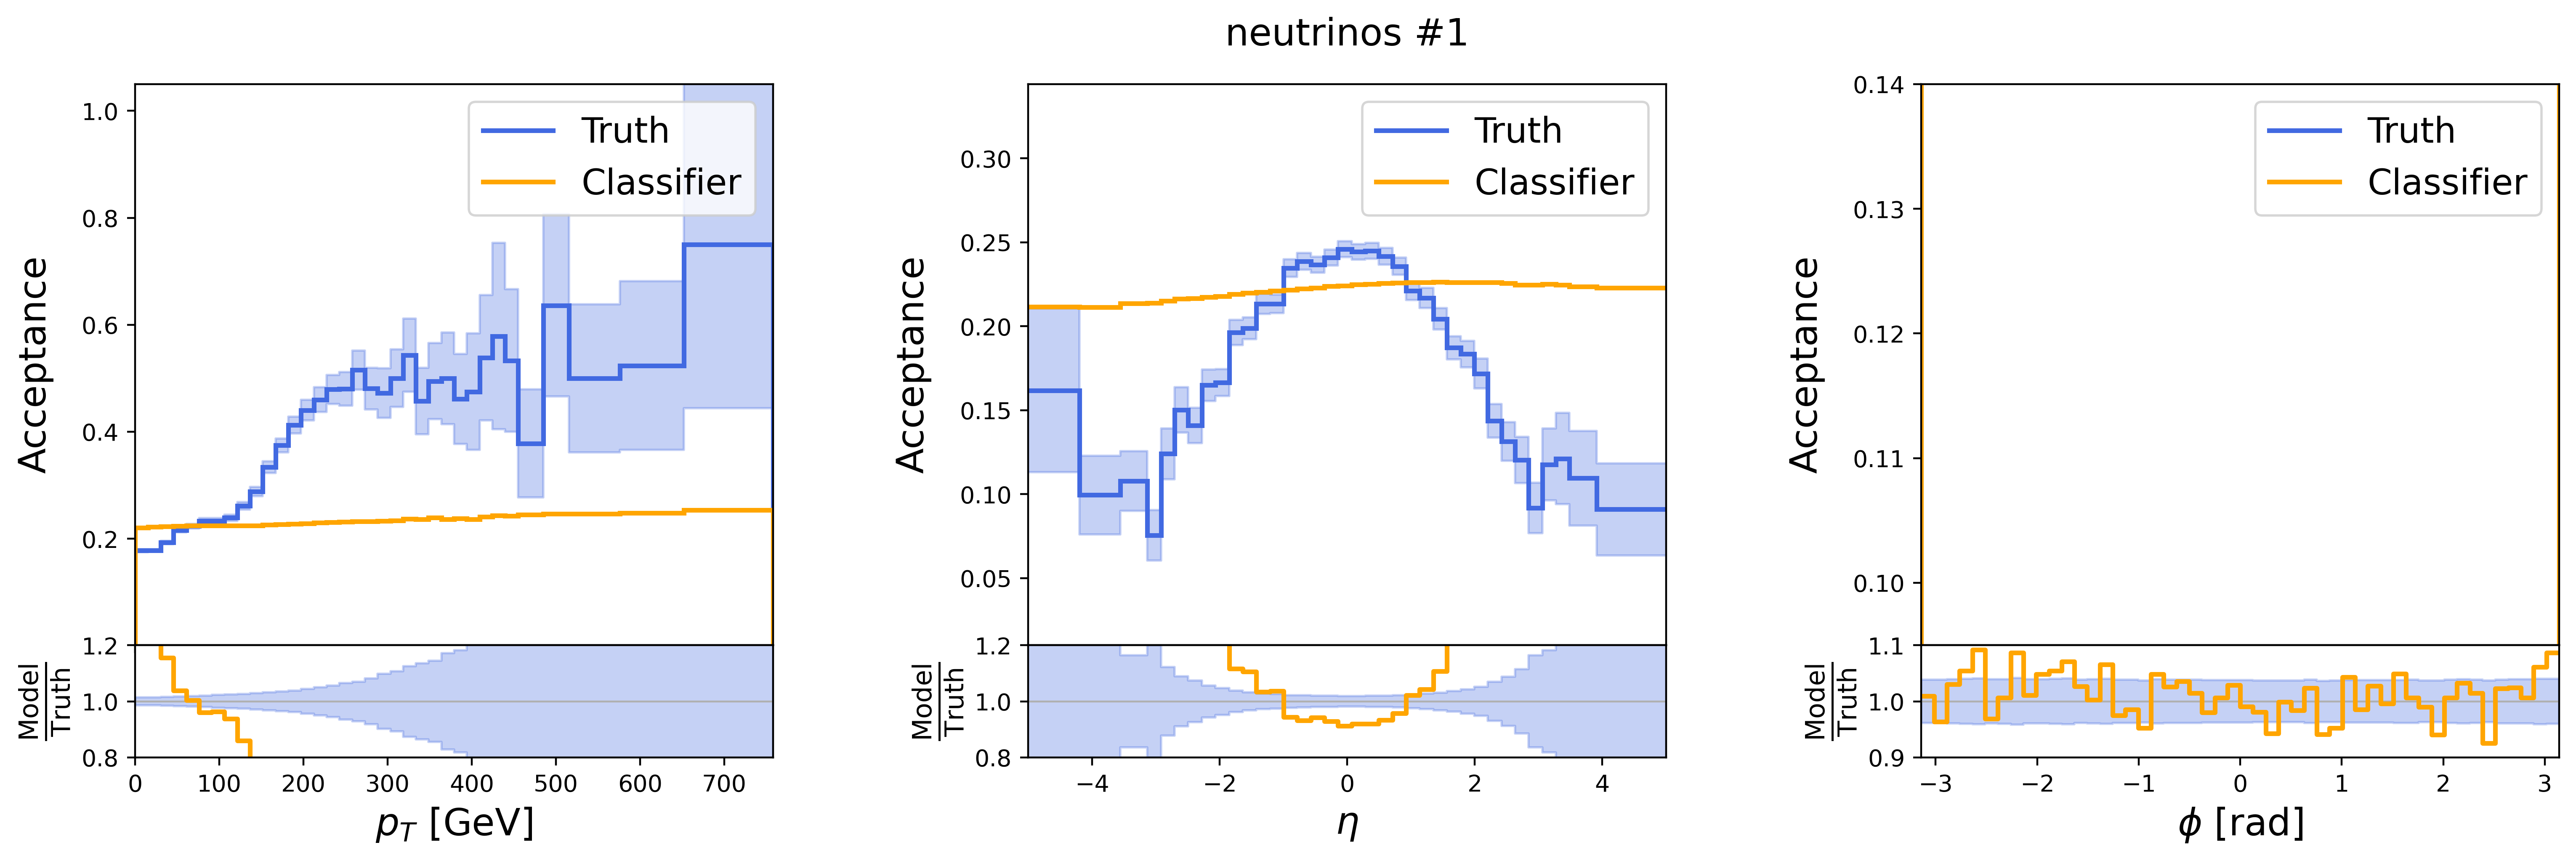

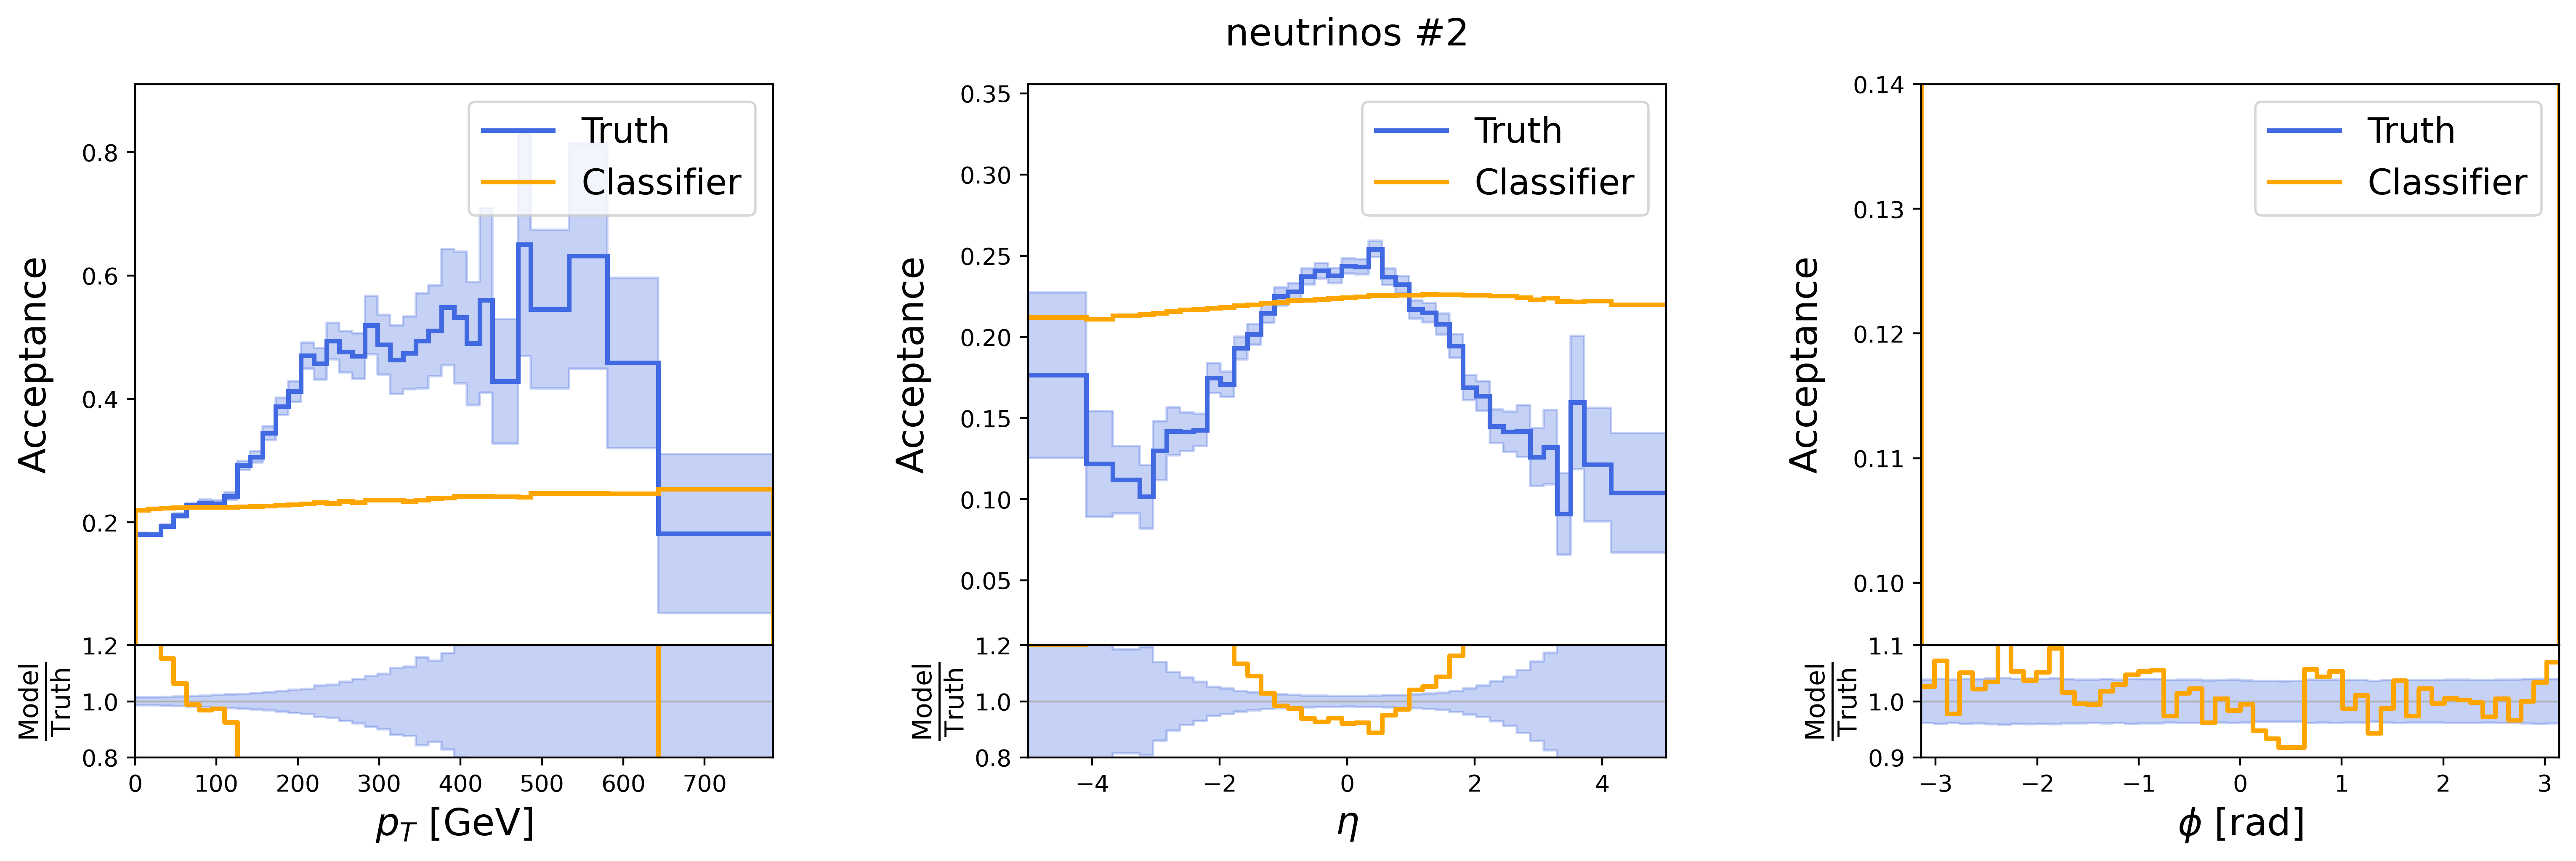

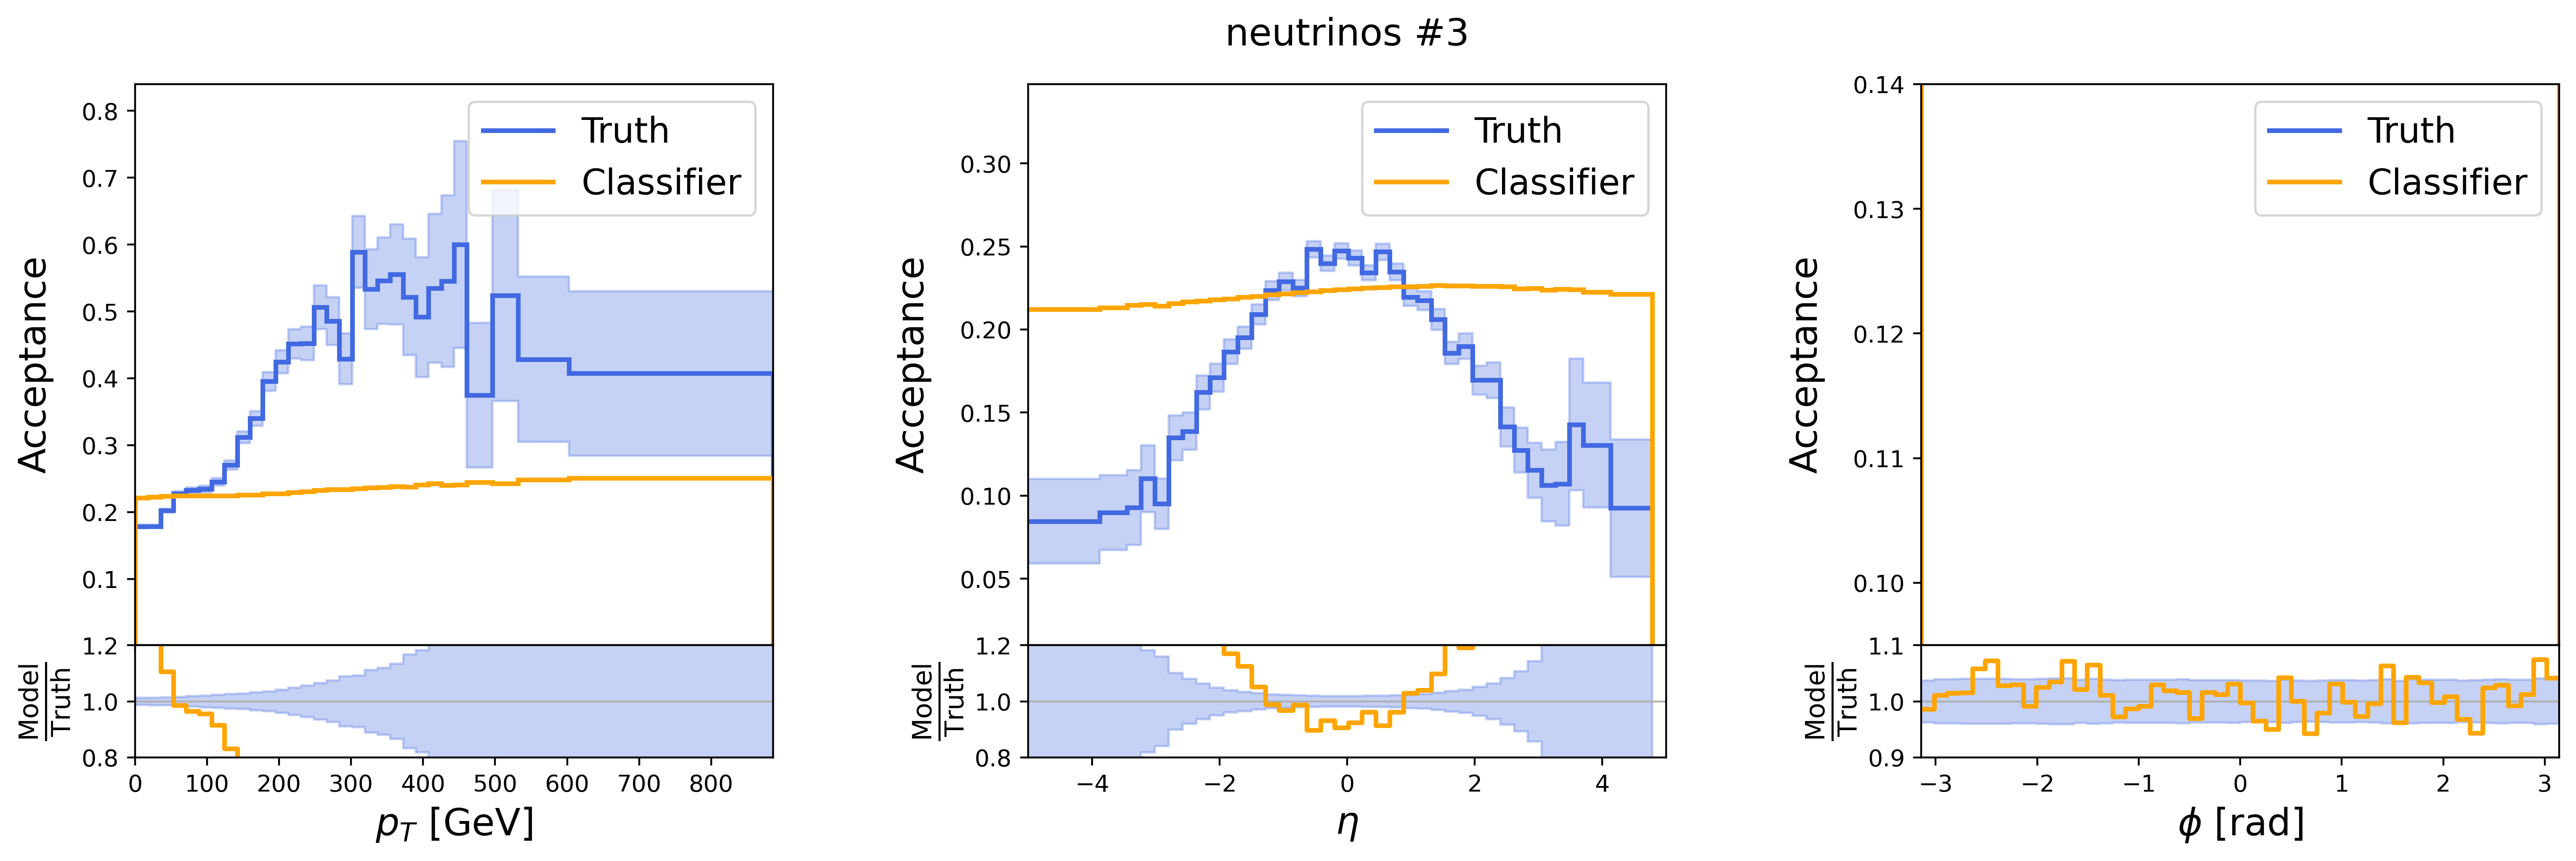

In [ ]:
acceptance.N_batch = np.inf # for final plots, want to make sure we use as much stats as possible
figs = acceptance.make_plots(model=model.cuda(),show=True)